# Homwork 1 solution

1. ## Backsolve
    1. $$x_1 = b_1/R_{11}, \quad x_{i+1} = \frac{b_{i+1} - \sum_{k=1}^i R_{i+1,k}x_k}{R_{i+1,i+1}}.$$ 
    2. $$x_n = b_n/R_{nn}, \quad x_{i} = \frac{b_{i} - \sum_{k=i+1}^n R_{i,k}x_k}{R_{i,i}}.$$

 ## Linear Data fit

In [3]:
using JLD
using LinearAlgebra
using Polynomials
using Plots
using BenchmarkTools
using Statistics

The norm of residual is: 498.56421135979997

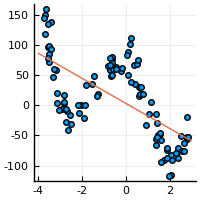

In [22]:
D = load("../hw1_p2_data.jld")["data"]
m = size(D)[1]

A = [ones(m,1) D[:,1]]
b = D[:,2]
xls = A\b 
p1 = Poly(xls)
xlim = (-4,3)

r = A*xls-b
print("The norm of residual is: ", norm(r,2))

pyplot(size=(200,200), legend=false)
plot1 = scatter(D[:,1],D[:,2])
plot!(t->p1(t), xlim...)

3. ## Polynomial data fit

The norm of residual for d = 1 is: 498.56421135979997
The norm of residual for d = 2 is: 473.93158732071345
The norm of residual for d = 3 is: 439.1465751343405
The norm of residual for d = 4 is: 194.79584942144604
The norm of residual for d = 5 is: 189.05547456952073


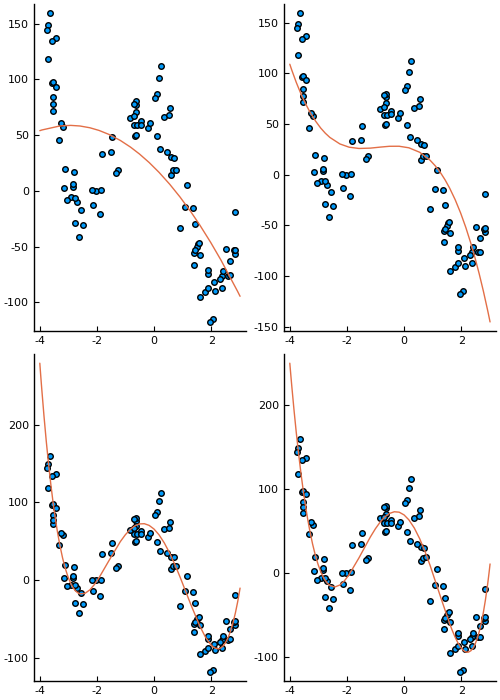

In [44]:
plot_list = []
for d in 1:5
    pp = polyfit(D[:,1], D[:,2], d)
    plot_t = scatter(D[:,1],D[:,2])
    plot!(t->pp(t),xlim..., grid = false)
    plot_list = push!(plot_list,plot_t)
    r= pp(D[:,1])-b;
    print("The norm of residual for d = $(d) is: $(norm(r,2))\n")
end
plot(plot_list[2],plot_list[3],plot_list[4],plot_list[5], layout=4)

4. ## Least norm solution

    1. There are two ways we can factor $A$. If we factor as $A = QR$, we get something like

    $$
    \underbrace{\begin{bmatrix} 
    \times  & \times & \times & \times & \times& \times \\
    \times  & \times & \times & \times & \times & \times\\
    \times  & \times & \times & \times & \times & \times\\
    \times  & \times & \times & \times & \times & \times
    \end{bmatrix} 
    }_{A}
    =
    \underbrace{\begin{bmatrix}
    \times  & \times & \times & \times  \\
    \times  & \times & \times & \times  \\
    \times  & \times & \times & \times  \\
    \times  & \times & \times & \times  \\
    \end{bmatrix} }_{Q}
    \underbrace{\begin{bmatrix} 
    \times  & \times 	& \times & \times & \times & \times\\
    0  		& \times 	& \times & \times & \times & \times\\
    0  		& 0		 	& \times & \times & \times& \times \\
    0  		& 0		 	& 0 & \times & \times & \times
    \end{bmatrix} }_{R}
    $$
    
    and we can solve 
    
    $$
    x = R^{-1}Q^Tb.
    $$
    
    The key advantage is that $Q$ is only $m\times m$, and $R$ is the same storage as $A$, so the only increase in storage is $m^2$. But, inverting $R$ is tricky, as it is not exactly triangular.

    We can also factor $A^T=QR$ to get something like
    
    $$
    \underbrace{\begin{bmatrix} 
        \times  & \times & \times & \times  \\
        \times  & \times & \times & \times \\
        \times  & \times & \times & \times \\
        \times  & \times & \times & \times \\
        \times  & \times & \times & \times \\
        \times  & \times & \times & \times 	
        \end{bmatrix}
    }_{A^T}
    =
    \underbrace{\begin{bmatrix} 
        \times  & \times & \times & \times  \\
        \times  & \times & \times & \times \\
        \times  & \times & \times & \times \\
        \times  & \times & \times & \times \\
        \times  & \times & \times & \times \\
        \times  & \times & \times & \times 	
        \end{bmatrix} }_{Q}
    \underbrace{\begin{bmatrix} 
        \times  & \times & \times & \times  \\
        0  & \times & \times & \times \\
        0  & 0 & \times & \times \\
        0  & 0 & 0 & \times 
        \end{bmatrix}. }_{R}
    $$

    Overall, we will solve this system in two steps:
    
    $$
     R^Tz = b, \quad Q^Tx = z.
    $$
    
    The first step is now much easier. 
    When $R$ is wide, it is tricky to figure out how to invert it. But when $R$ is square, it is easy to ``invert" through backsolving. 

    The second step is tricky, because $Q^T$ is wide, and not easily left invertible. In fact, there are many solutions for $x$. One possible solution is $x = QQ^Tz$, which is the least squares solution, and perhaps easiest to compute in this context. 

    In this regime, the solve system $z = R^{-T}b$ takes $O(m^2)$ flops, and $x = Qz$ requires $O(mn)$ flops, for a total of $O(mn+m^2)$ flops for the solve, and an extra $O(nm^2)$ flops for the original QR factorization.
    


    B. Here's a code for timing

In [5]:
function qrtest(A,b)
    F = qr(A') 
    return F.Q*(F.R'\b)
end

m = [10, 100, 100, 100, 100]
n = [20, 200, 2000, 20000, 200000]

bench_times = []

for k in 1:5
    println("Benchmarking for m = $(m[k]) and n = $(n[k])")

    A = randn(m[k],n[k])
    x = randn(n[k])
    b = A*x

    t_qr = @benchmark qrtest($A,$b) samples = 10 seconds = 50

    t_bs = @benchmark $A\$b samples = 10 seconds = 50

    push!(bench_times, (time_qr = t_qr, time_bs = t_bs))
    println(bench_times[k])
end

Benchmarking for m = 10 and n = 20
(time_qr = Trial(16.043 μs), time_bs = Trial(18.324 μs))
Benchmarking for m = 100 and n = 200
(time_qr = Trial(839.127 μs), time_bs = Trial(1.689 ms))
Benchmarking for m = 100 and n = 2000
(time_qr = Trial(3.882 ms), time_bs = Trial(17.728 ms))
Benchmarking for m = 100 and n = 20000
(time_qr = Trial(39.769 ms), time_bs = Trial(260.832 ms))
Benchmarking for m = 100 and n = 200000
(time_qr = Trial(665.707 ms), time_bs = Trial(5.214 s))


  C. Let $x_{ln}$ be the least norm solution to

$$ \min_{x\in \mathbb{R}^n} \|x\|_x^2 \text{ s.t. } Ax = b.$$

The solution $x_{ln}$ can be decomposed as $x_{ln} = x_1 + x_2$, where $x_1\in \mathcal{R}(A^T)$, $x_2 \in \mathcal{N}(A)$ and $ x_1^Tx_2 = 0$. Since $Ax_2 = 0$, the component of $x_{ln}$ along $\mathcal{N}(A)$ must be zero. So, $x_{ln} \in \mathcal{R}(A^T)$. 

Consider the QR decomposition of $A^T = Q R$, where 

$$ Q = \begin{bmatrix}\hat{Q} & \bar{Q}\end{bmatrix}, \text{ and } R = \begin{bmatrix}\hat{R}\\ 0 \end{bmatrix}.$$

Here $\hat{Q} \in \mathbb{R}^{n \times m}$, $\bar{Q} \in \mathbb{R}^{n \times (n-m)}$ and $R \in \mathbb{R}^{m \times m}$. Additionally, we have $\mathcal{R}(A^T) = \mathcal{R}(\hat{Q})$.

Since, $x_{ln} \in \mathcal{R}(A^T)$, $\mathcal{R}(A^T) = \mathcal{R}(\hat{Q})$, and $\mathcal{N}(A) = \mathcal{R}(\bar{Q})$, we have $\bar{Q}^Tx_{ln} = 0$. Also, since $x_{ln}$ satisfies the equation $Ax = b$, we have 

\begin{align*}&(QR)^Tx_{ln} = b\\
\Rightarrow &\hat{R}^T\hat{Q}^Tx_{ln} = b\end{align*}. 

Note that $x_{ln}$ that satisfies $\hat{R}^T\hat{Q}^Tx_{ln} = b$ and $\bar{Q}^Tx_{ln} = 0$ is $x_{ln} = \hat{Q}\hat{R}^{-T}b$.